# Product Recommendation using Deep Learning using Graph Convolutional Networks and Graph Attention Networks

## Data Preprocessing

In [34]:
import pandas as pd

df = pd.read_csv('UrbanEdgeApparel.csv')

def preprocess(original_df):
    df_copy = original_df.copy(deep=True)
    df_copy = df_copy.dropna()
    
    df_copy['Order Date'] = pd.to_datetime(df_copy['Order Date'])
    df_copy['Order Day of Week'] = df_copy['Order Day of Week'].astype('category')
    df_copy['Order Month'] = df_copy['Order Month'].astype('category')
    df_copy['Order Year'] = df_copy['Order Year'].astype(int)

    df_copy['Product Unit Selling Price'] = df_copy['Product Unit Selling Price'].astype(float)
    df_copy['Product Quantity'] = df_copy['Product Quantity'].astype(int)
    df_copy['Total Selling Price'] = df_copy['Total Selling Price'].astype(float)
    df_copy['Shipment ID'] = df_copy['Shipment ID'].astype(int)
    df_copy['Shipment Number'] = df_copy['Shipment Number'].astype(int)

    df_copy['Order Status'] = df_copy['Order Status'].astype('category')
    df_copy['Payment Status'] = df_copy['Payment Status'].astype('category')
    df_copy['Shipping Address Type'] = df_copy['Shipping Address Type'].astype('category')

    df_copy = df_copy.drop_duplicates()

    return df_copy

df = preprocess(df)
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 83189 entries, 0 to 89643
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Order ID                    83189 non-null  int64         
 1   Order Status                83189 non-null  category      
 2   Order Date                  83189 non-null  datetime64[ns]
 3   Order Day of Week           83189 non-null  category      
 4   Order Month                 83189 non-null  category      
 5   Order Year                  83189 non-null  int64         
 6   Customer ID                 83189 non-null  object        
 7   Company ID                  83189 non-null  object        
 8   Product ID                  83189 non-null  object        
 9   Product Variant ID          83189 non-null  object        
 10  Product Unit Selling Price  83189 non-null  float64       
 11  Product Quantity            83189 non-null  int64         


## Graph Creation

In [2]:
import networkx as nx

def create_graph(df, variant=False):
    G = nx.Graph()

    products = df['Product Variant ID'].unique() if variant else df['Product ID'].unique()
    G.add_nodes_from(products)

    for order_id, group in df.groupby('Order ID'):
        products_in_order = group['Product Variant ID'].unique() if variant else group['Product ID'].unique()
        for i in range(len(products_in_order)):
            for j in range(i + 1, len(products_in_order)):
                # Add an edge between products that are purchased together
                G.add_edge(products_in_order[i], products_in_order[j])

    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")

    return G

G = create_graph(df)

Number of nodes: 272
Number of edges: 18400


## Exploratory Analysis

In [3]:
a = df.groupby('Order ID')['Product Variant ID'].unique()
a.iloc[3]

# avg order size
print('Average num. products ordered:', df.groupby('Order ID')['Product Variant ID'].count().mean())

Average num. products ordered: 8.611697722567287


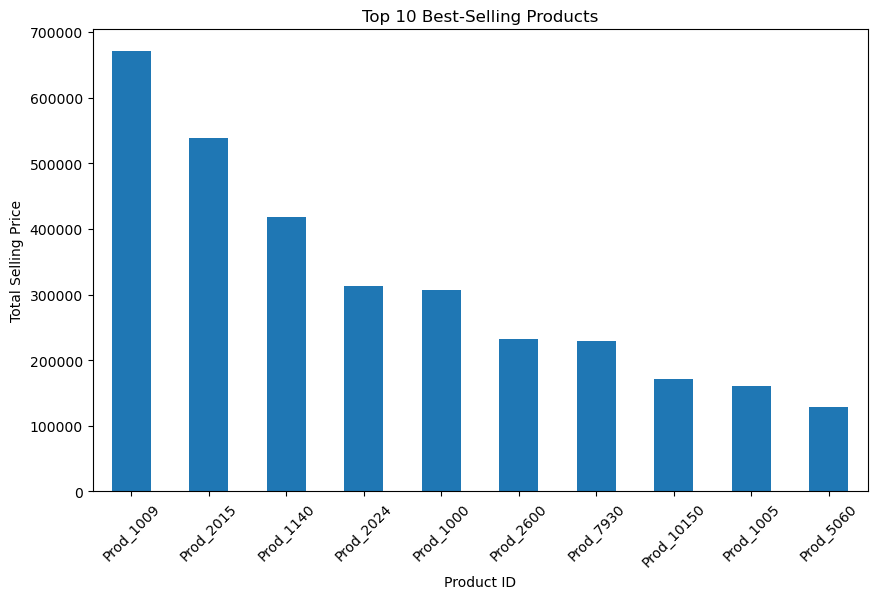

In [29]:
import matplotlib.pyplot as plt

top_products = df.groupby('Product ID')['Total Selling Price'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_products.plot(kind='bar')
plt.title('Top 10 Best-Selling Products')
plt.xlabel('Product ID')
plt.ylabel('Total Selling Price')
plt.xticks(rotation=45)
plt.show()


13:48:00 - cmdstanpy - INFO - Chain [1] start processing


          ds        y
0 2013-04-17   190.25
1 2013-04-18    97.50
2 2013-04-19   385.25
3 2013-04-22   263.45
4 2013-04-24  4430.85


13:48:00 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1682.2843590409661
RMSE: 2971.365156300957
MAPE: 1161.5884678531538%


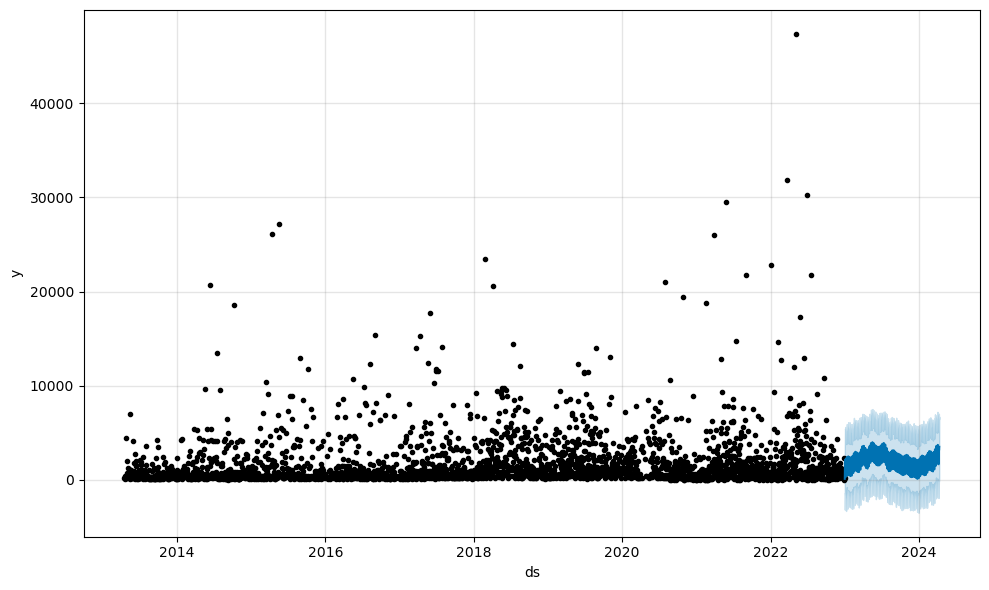

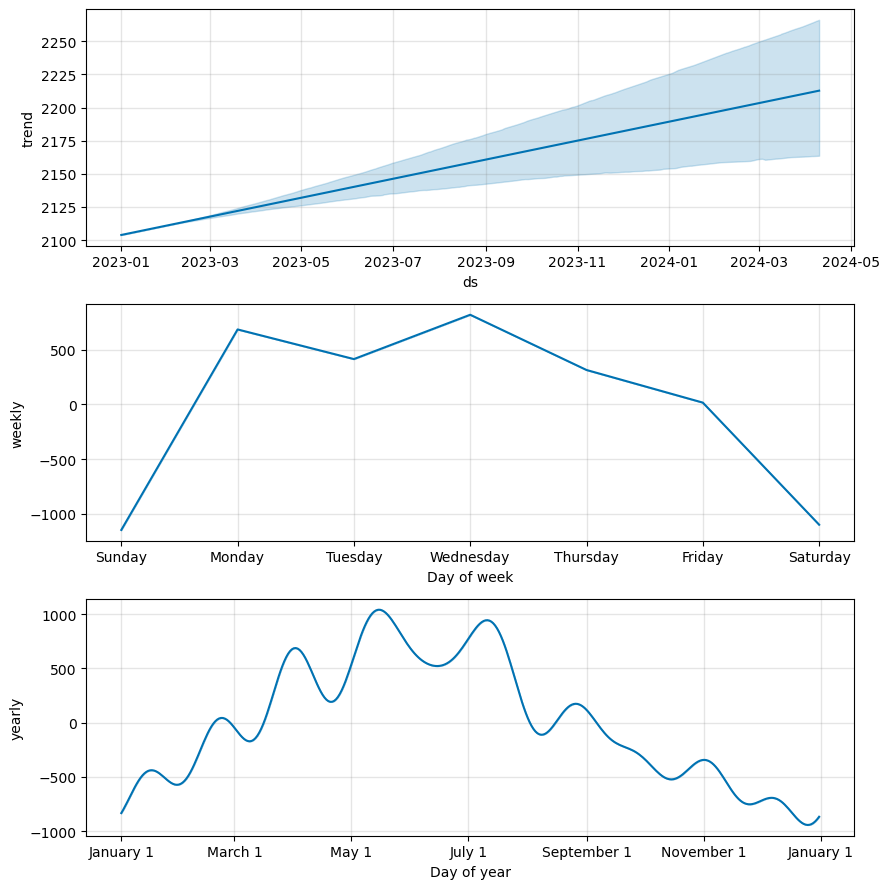

In [33]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

df1 = pd.read_csv('UrbanEdgeApparel.csv')

df1['Order Date'] = pd.to_datetime(df1['Order Date'])
company_sales = df1.groupby('Order Date')['Total Selling Price'].sum().reset_index()
company_sales.columns = ['ds', 'y']

model = Prophet()
train = company_sales[company_sales['ds'] < '2023-01-01'].copy()
test = company_sales[company_sales['ds'] >= '2023-01-01'].copy()

model.fit(train)

future_dates = model.make_future_dataframe(periods=len(test), include_history=False)  # Next 2 years
forecast = model.predict(future_dates)

test.loc[:, 'yhat'] = forecast['yhat'].values
test.loc[:, 'yhat_lower'] = forecast['yhat_lower'].values
test.loc[:, 'yhat_upper'] = forecast['yhat_upper'].values

mae = mean_absolute_error(test['y'], test['yhat'])
rmse = mean_squared_error(test['y'], test['yhat'], squared=False)
mape = (abs((test['y'] - test['yhat']) / test['y'])).mean() * 100

model.plot(forecast)
model.plot_components(forecast)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")


## Graph Visualization

In [ ]:
from pyvis.network import Network
import networkx as nx

net = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white")

net.from_nx(G)

net.set_options("""
var options = {
  "nodes": {
    "shape": "dot",
    "scaling": {
      "min": 10,
      "max": 30
    },
    "font": {
      "size": 12,
      "face": "Tahoma"
    }
  },
  "edges": {
    "width": 0.15,
    "color": {"inherit": "from"},
    "smooth": {"type": "continuous"}
  },
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -10000,
      "springLength": 100,
      "springConstant": 0.0001
    },
    "minVelocity": 0.25
  }
}
""")

net.show("massive_graph.html")

## Graph Convolutional Network

In [5]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import from_networkx
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

class GNNRecommendationModel(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(GNNRecommendationModel, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

num_products = G.number_of_nodes()

node_features = torch.eye(num_products)

data = from_networkx(G)

data.y = torch.randint(0, num_products, (num_products,))

model = GNNRecommendationModel(num_node_features=num_products, hidden_channels=16, num_classes=num_products)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()

data.x = node_features

loss_values = []
accuracy_values = []
precision_values = []
recall_values = []
f1_values = []
epochs = []

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        with torch.no_grad():
            model.eval()
            pred = out.argmax(dim=1)
            accuracy = accuracy_score(data.y.cpu().numpy(), pred.cpu().numpy())
            precision = precision_score(data.y.cpu().numpy(), pred.cpu().numpy(), average='macro', zero_division=1)
            recall = recall_score(data.y.cpu().numpy(), pred.cpu().numpy(), average='macro', zero_division=1)
            f1 = f1_score(data.y.cpu().numpy(), pred.cpu().numpy(), average='macro')

            loss_values.append(loss.item())
            accuracy_values.append(accuracy)
            precision_values.append(precision)
            recall_values.append(recall)
            f1_values.append(f1)
            epochs.append(epoch)

            print(f'Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1}')

torch.save(model.state_dict(), 'gnn_recommendation_model.pth')


Epoch 0, Loss: 5.605848789215088, Accuracy: 0.003676470588235294, Precision: 0.9423279033105623, Recall: 0.023121387283236993, F1-score: 0.0002569043031470777
Epoch 20, Loss: 4.848453044891357, Accuracy: 0.025735294117647058, Precision: 0.9741701594642771, Recall: 0.01764705882352941, F1-score: 0.00993673167020382
Epoch 40, Loss: 4.46509313583374, Accuracy: 0.04411764705882353, Precision: 0.918472251690541, Recall: 0.03215686274509804, F1-score: 0.019146559055728606
Epoch 60, Loss: 4.083805084228516, Accuracy: 0.07720588235294118, Precision: 0.8617081737575096, Recall: 0.06254901960784313, F1-score: 0.035812608315958436
Epoch 80, Loss: 3.7502362728118896, Accuracy: 0.10661764705882353, Precision: 0.8152690773279009, Recall: 0.10941176470588236, F1-score: 0.06869243828067358
Epoch 100, Loss: 3.42815899848938, Accuracy: 0.16544117647058823, Precision: 0.7736735704382763, Recall: 0.17392156862745098, F1-score: 0.13765406162464983
Epoch 120, Loss: 3.1544227600097656, Accuracy: 0.2352941176

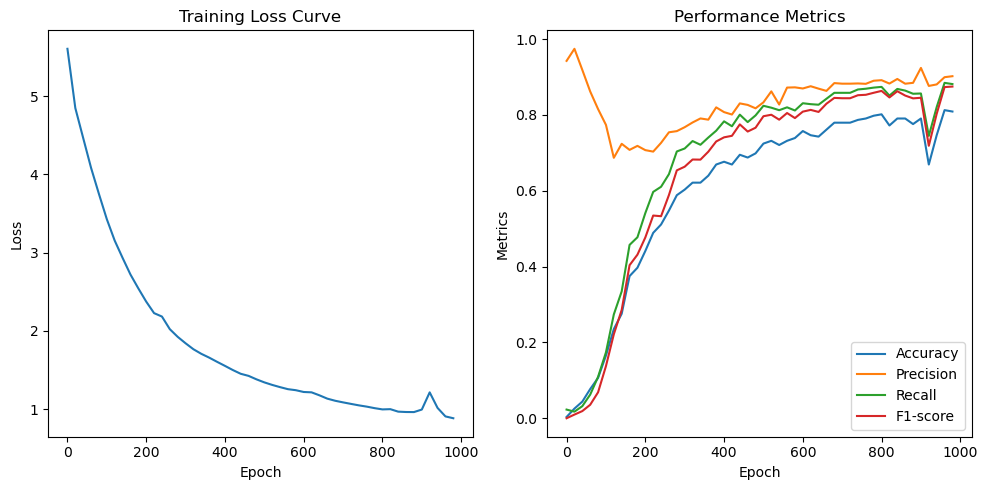

MAP: 0.04055187310811362
NDCG@10: 0.03885653187360938
AUC-ROC: 0.5859712792269987


In [6]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_values, label='Accuracy')
plt.plot(epochs, precision_values, label='Precision')
plt.plot(epochs, recall_values, label='Recall')
plt.plot(epochs, f1_values, label='F1-score')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Performance Metrics')
plt.legend()

plt.tight_layout()
plt.show()

from sklearn.metrics import average_precision_score, ndcg_score, roc_auc_score

def evaluate_map(model, data):
    model.eval()
    with torch.no_grad():
        product_embeddings = model(data.x, data.edge_index)
        scores = torch.matmul(product_embeddings, product_embeddings.t())
        ap_scores = []
        for i in range(len(data.y)):
            true_labels = (data.y == data.y[i]).float()
            pred_scores = scores[i]
            ap_scores.append(average_precision_score(true_labels.cpu().numpy(), pred_scores.cpu().numpy()))
        return np.mean(ap_scores)

def evaluate_ndcg(model, data, k=10):
    model.eval()
    with torch.no_grad():
        product_embeddings = model(data.x, data.edge_index)
        scores = torch.matmul(product_embeddings, product_embeddings.t())
        ndcg_scores = []
        for i in range(len(data.y)):
            true_labels = (data.y == data.y[i]).float()
            pred_scores = scores[i]
            ndcg_scores.append(ndcg_score([true_labels.cpu().numpy()], [pred_scores.cpu().numpy()], k=k))
        return np.mean(ndcg_scores)

def evaluate_auc_roc(model, data):
    model.eval()
    with torch.no_grad():
        product_embeddings = model(data.x, data.edge_index)
        scores = torch.matmul(product_embeddings, product_embeddings.t())
        true_labels = (data.y == data.y.unsqueeze(1)).float().cpu().numpy()
        pred_scores = scores.cpu().numpy()
        return roc_auc_score(true_labels.flatten(), pred_scores.flatten())

map_score = evaluate_map(model, data)
ndcg_score = evaluate_ndcg(model, data)
auc_roc_score = evaluate_auc_roc(model, data)

print(f"MAP: {map_score}")
print(f"NDCG@10: {ndcg_score}")
print(f"AUC-ROC: {auc_roc_score}")



In [26]:
def recommend_products(model, product_ids, n_recommendations=5):
    model.eval()
    with torch.no_grad():
        product_embeddings = model(data.x, data.edge_index)
        selected_embeddings = product_embeddings[product_ids]
        
        similarity_scores = torch.matmul(selected_embeddings, product_embeddings.t())
        similarity_scores = similarity_scores.mean(dim=0)
        
        _, recommended_product_ids = similarity_scores.topk(n_recommendations + len(product_ids))
        recommended_product_ids = [pid.item() for pid in recommended_product_ids if pid not in product_ids][:n_recommendations]
        
        return recommended_product_ids

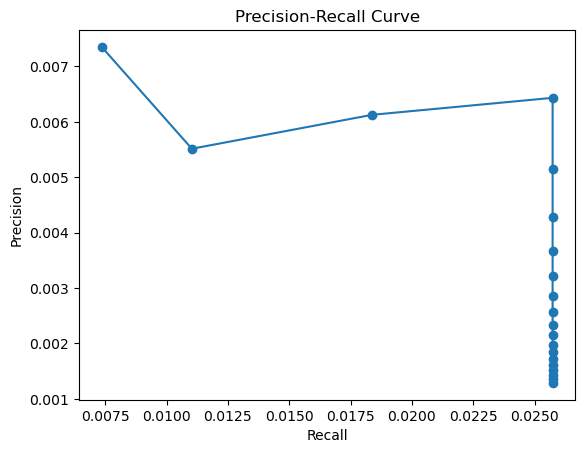

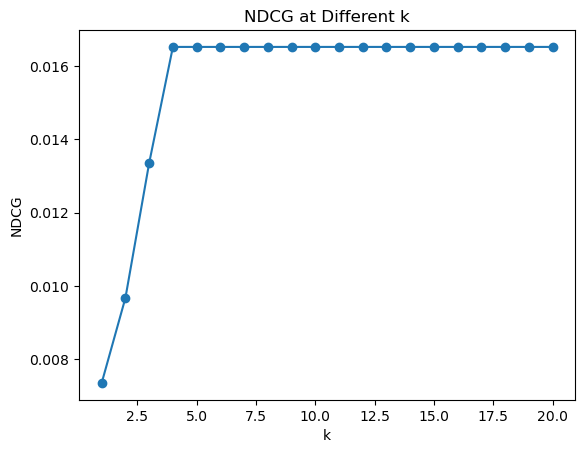

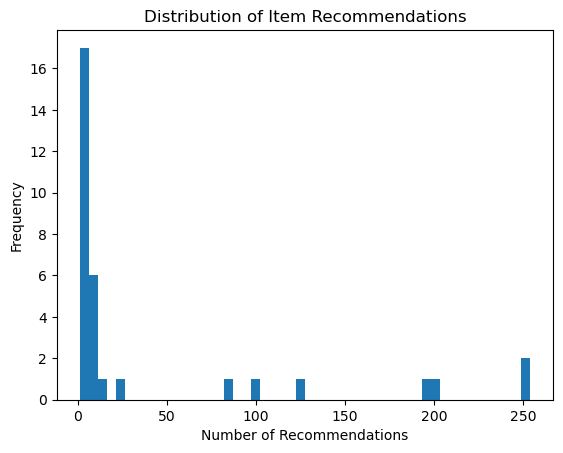

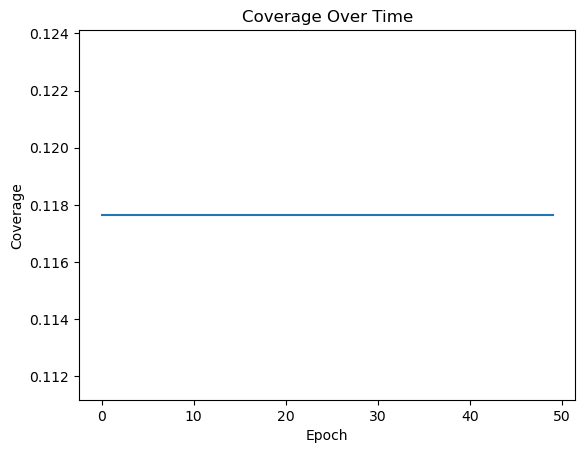

In [27]:
y_true = []
y_pred = []

for product_id in range(num_products):
    bought_products = [product_id]
    recommended_products = recommend_products(model, bought_products)
    y_true.append([data.y[product_id].item()])
    y_pred.append(recommended_products)

y_true = [list(arr) for arr in y_true]
y_pred = [list(arr) for arr in y_pred]

def precision_at_k(y_true, y_pred, k):
    num_hits = sum([1 if y_true[i][0] in y_pred[i][:k] else 0 for i in range(len(y_true))])
    return num_hits / (len(y_pred) * k)

def recall_at_k(y_true, y_pred, k):
    num_hits = sum([1 if y_true[i][0] in y_pred[i][:k] else 0 for i in range(len(y_true))])
    return num_hits / len(y_true)

def f1_score_at_k(y_true, y_pred, k):
    prec = precision_at_k(y_true, y_pred, k)
    rec = recall_at_k(y_true, y_pred, k)
    if (prec + rec) == 0:
        return 0.0
    return 2 * (prec * rec) / (prec + rec)

def dcg_at_k(y_true, y_pred, k):
    dcg = 0.0
    for i, p in enumerate(y_pred[:k]):
        if p in y_true:
            dcg += 1.0 / np.log2(i + 2)
    return dcg

def ndcg_at_k(y_true, y_pred, k):
    ideal_dcg = dcg_at_k(y_true, y_true, k)
    if not ideal_dcg:
        return 0.0
    return dcg_at_k(y_true, y_pred, k) / ideal_dcg

def coverage(y_pred, total_items):
    recommended_items = set([item for sublist in y_pred for item in sublist])
    return len(recommended_items) / total_items

def plot_precision_recall_curve(y_true, y_pred, k_values):
    precisions = [precision_at_k(y_true, y_pred, k) for k in k_values]
    recalls = [recall_at_k(y_true, y_pred, k) for k in k_values]

    plt.plot(recalls, precisions, marker='o')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

def plot_ndcg(y_true, y_pred, k_values):
    ndcgs = [np.mean([ndcg_at_k(y_true[i], y_pred[i], k) for i in range(len(y_true))]) for k in k_values]

    plt.plot(k_values, ndcgs, marker='o')
    plt.xlabel('k')
    plt.ylabel('NDCG')
    plt.title('NDCG at Different k')
    plt.show()

def plot_recommendation_histogram(y_pred):
    from collections import Counter

    recommended_items = [item for sublist in y_pred for item in sublist]
    item_counts = Counter(recommended_items)

    plt.hist(item_counts.values(), bins=50)
    plt.xlabel('Number of Recommendations')
    plt.ylabel('Frequency')
    plt.title('Distribution of Item Recommendations')
    plt.show()

def plot_coverage_over_time(y_pred, total_items, epochs):
    coverage_values = [coverage(y_pred, total_items) for _ in range(epochs)]

    plt.plot(range(epochs), coverage_values)
    plt.xlabel('Epoch')
    plt.ylabel('Coverage')
    plt.title('Coverage Over Time')
    plt.show()

k_values = range(1, 21)

plot_precision_recall_curve(y_true, y_pred, k_values)
plot_ndcg(y_true, y_pred, k_values)
plot_recommendation_histogram(y_pred)
plot_coverage_over_time(y_pred, num_products, len(epochs))

## Graph Attention Network

In [22]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import from_networkx
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

class GATRecommendationModel(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes, num_heads):
        super(GATRecommendationModel, self).__init__()
        self.conv1 = GATConv(num_node_features, hidden_channels, heads=num_heads)
        self.conv2 = GATConv(hidden_channels * num_heads, num_classes, heads=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

num_products = G.number_of_nodes()

node_features = torch.eye(num_products)

data = from_networkx(G)

data.y = torch.randint(0, num_products, (num_products,))

gat_model = GATRecommendationModel(num_node_features=num_products, hidden_channels=16, num_classes=num_products, num_heads=2)

optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()

data.x = node_features

loss_values = []
accuracy_values = []
precision_values = []
recall_values = []
f1_values = []
epochs = []

for epoch in range(1000):
    gat_model.train()
    optimizer.zero_grad()
    out = gat_model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        with torch.no_grad():
            gat_model.eval()
            pred = out.argmax(dim=1)
            accuracy = accuracy_score(data.y.cpu().numpy(), pred.cpu().numpy())
            precision = precision_score(data.y.cpu().numpy(), pred.cpu().numpy(), average='macro', zero_division=1)
            recall = recall_score(data.y.cpu().numpy(), pred.cpu().numpy(), average='macro', zero_division=1)
            f1 = f1_score(data.y.cpu().numpy(), pred.cpu().numpy(), average='macro')

            loss_values.append(loss.item())
            accuracy_values.append(accuracy)
            precision_values.append(precision)
            recall_values.append(recall)
            f1_values.append(f1)
            epochs.append(epoch)

            print(f'Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1}')

# Save model
torch.save(gat_model.state_dict(), 'gat_recommendation_model.pth')


Epoch 0, Loss: 5.605716228485107, Accuracy: 0.003676470588235294, Precision: 0.9618282270215972, Recall: 0.008287292817679558, F1-score: 0.0008499787505312368
Epoch 20, Loss: 3.4061005115509033, Accuracy: 0.1323529411764706, Precision: 0.8575417009795235, Recall: 0.11574074074074073, F1-score: 0.04982948200707589
Epoch 40, Loss: 2.9305436611175537, Accuracy: 0.15808823529411764, Precision: 0.8414181253669625, Recall: 0.16111111111111112, F1-score: 0.09397580197580198
Epoch 60, Loss: 3.2025113105773926, Accuracy: 0.125, Precision: 0.8386530288242954, Recall: 0.11342592592592592, F1-score: 0.06543871023731183
Epoch 80, Loss: 2.7044878005981445, Accuracy: 0.16911764705882354, Precision: 0.8594608981804104, Recall: 0.15462962962962962, F1-score: 0.09864616757058617
Epoch 100, Loss: 2.483104944229126, Accuracy: 0.17647058823529413, Precision: 0.8508655541988875, Recall: 0.17129629629629628, F1-score: 0.11357503298774156
Epoch 120, Loss: 2.5371148586273193, Accuracy: 0.1875, Precision: 0.857

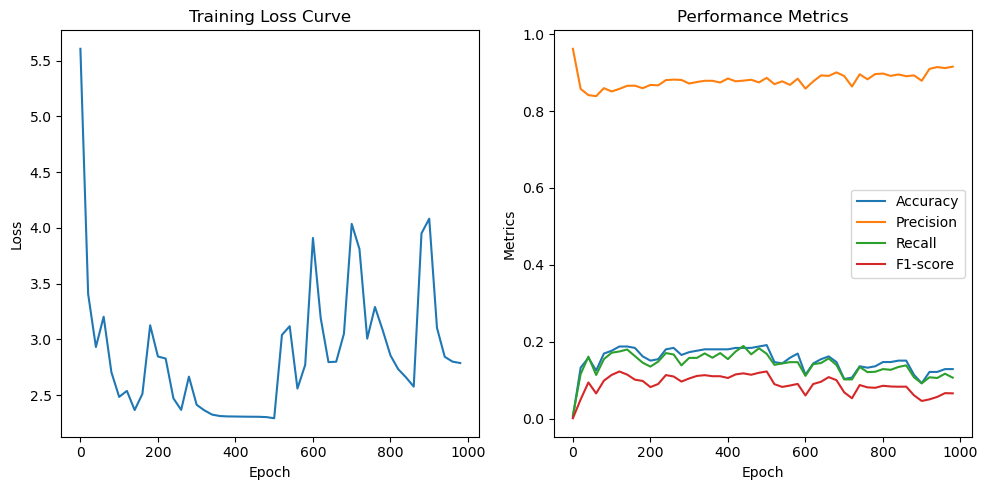

MAP: 0.03450848008359815
NDCG@10: 0.03717648467699336
AUC-ROC: 0.6625300740344704


In [23]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_values, label='Accuracy')
plt.plot(epochs, precision_values, label='Precision')
plt.plot(epochs, recall_values, label='Recall')
plt.plot(epochs, f1_values, label='F1-score')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Performance Metrics')
plt.legend()

plt.tight_layout()
plt.show()

from sklearn.metrics import average_precision_score, ndcg_score, roc_auc_score

def evaluate_map(model, data):
    model.eval()
    with torch.no_grad():
        product_embeddings = model(data.x, data.edge_index)
        scores = torch.matmul(product_embeddings, product_embeddings.t())
        ap_scores = []
        for i in range(len(data.y)):
            true_labels = (data.y == data.y[i]).float()
            pred_scores = scores[i]
            ap_scores.append(average_precision_score(true_labels.cpu().numpy(), pred_scores.cpu().numpy()))
        return np.mean(ap_scores)

def evaluate_ndcg(model, data, k=10):
    model.eval()
    with torch.no_grad():
        product_embeddings = model(data.x, data.edge_index)
        scores = torch.matmul(product_embeddings, product_embeddings.t())
        ndcg_scores = []
        for i in range(len(data.y)):
            true_labels = (data.y == data.y[i]).float()
            pred_scores = scores[i]
            ndcg_scores.append(ndcg_score([true_labels.cpu().numpy()], [pred_scores.cpu().numpy()], k=k))
        return np.mean(ndcg_scores)

def evaluate_auc_roc(model, data):
    model.eval()
    with torch.no_grad():
        product_embeddings = model(data.x, data.edge_index)
        scores = torch.matmul(product_embeddings, product_embeddings.t())
        true_labels = (data.y == data.y.unsqueeze(1)).float().cpu().numpy()
        pred_scores = scores.cpu().numpy()
        return roc_auc_score(true_labels.flatten(), pred_scores.flatten())

map_score = evaluate_map(gat_model, data)
ndcg_score = evaluate_ndcg(gat_model, data)
auc_roc_score = evaluate_auc_roc(gat_model, data)

print(f"MAP: {map_score}")
print(f"NDCG@10: {ndcg_score}")
print(f"AUC-ROC: {auc_roc_score}")



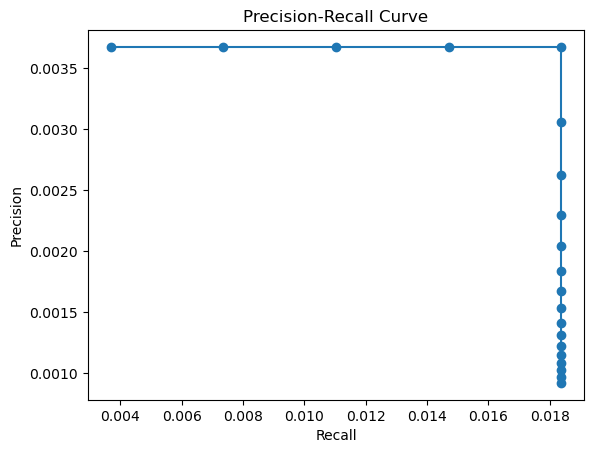

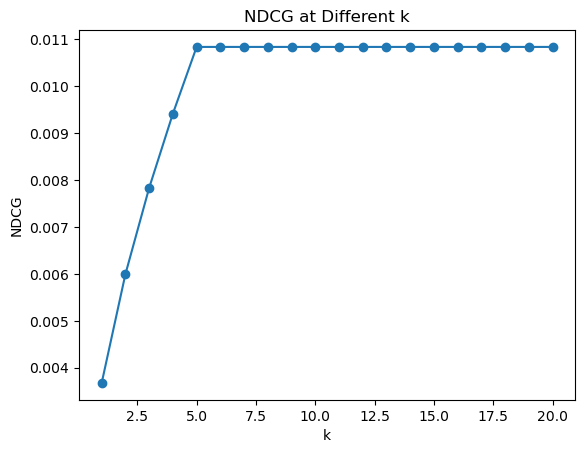

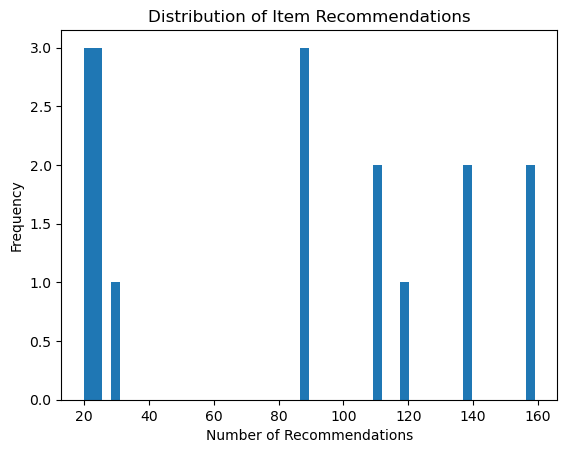

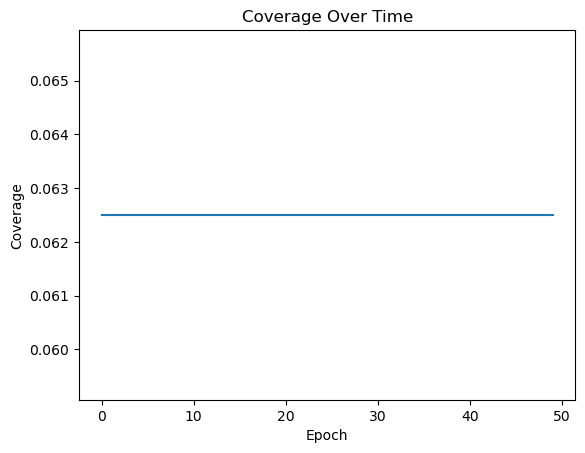

In [28]:
y_true = []
y_pred = []

for product_id in range(num_products):
    bought_products = [product_id]
    recommended_products = recommend_products(gat_model, bought_products)
    y_true.append([data.y[product_id].item()])
    y_pred.append(recommended_products)

y_true = [list(arr) for arr in y_true]
y_pred = [list(arr) for arr in y_pred]

def precision_at_k(y_true, y_pred, k):
    num_hits = sum([1 if y_true[i][0] in y_pred[i][:k] else 0 for i in range(len(y_true))])
    return num_hits / (len(y_pred) * k)

def recall_at_k(y_true, y_pred, k):
    num_hits = sum([1 if y_true[i][0] in y_pred[i][:k] else 0 for i in range(len(y_true))])
    return num_hits / len(y_true)

def f1_score_at_k(y_true, y_pred, k):
    prec = precision_at_k(y_true, y_pred, k)
    rec = recall_at_k(y_true, y_pred, k)
    if (prec + rec) == 0:
        return 0.0
    return 2 * (prec * rec) / (prec + rec)

def dcg_at_k(y_true, y_pred, k):
    dcg = 0.0
    for i, p in enumerate(y_pred[:k]):
        if p in y_true:
            dcg += 1.0 / np.log2(i + 2)
    return dcg

def ndcg_at_k(y_true, y_pred, k):
    ideal_dcg = dcg_at_k(y_true, y_true, k)
    if not ideal_dcg:
        return 0.0
    return dcg_at_k(y_true, y_pred, k) / ideal_dcg

def coverage(y_pred, total_items):
    recommended_items = set([item for sublist in y_pred for item in sublist])
    return len(recommended_items) / total_items

def plot_precision_recall_curve(y_true, y_pred, k_values):
    precisions = [precision_at_k(y_true, y_pred, k) for k in k_values]
    recalls = [recall_at_k(y_true, y_pred, k) for k in k_values]

    plt.plot(recalls, precisions, marker='o')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

def plot_ndcg(y_true, y_pred, k_values):
    ndcgs = [np.mean([ndcg_at_k(y_true[i], y_pred[i], k) for i in range(len(y_true))]) for k in k_values]

    plt.plot(k_values, ndcgs, marker='o')
    plt.xlabel('k')
    plt.ylabel('NDCG')
    plt.title('NDCG at Different k')
    plt.show()

def plot_recommendation_histogram(y_pred):
    from collections import Counter

    recommended_items = [item for sublist in y_pred for item in sublist]
    item_counts = Counter(recommended_items)

    plt.hist(item_counts.values(), bins=50)
    plt.xlabel('Number of Recommendations')
    plt.ylabel('Frequency')
    plt.title('Distribution of Item Recommendations')
    plt.show()

def plot_coverage_over_time(y_pred, total_items, epochs):
    coverage_values = [coverage(y_pred, total_items) for _ in range(epochs)]

    plt.plot(range(epochs), coverage_values)
    plt.xlabel('Epoch')
    plt.ylabel('Coverage')
    plt.title('Coverage Over Time')
    plt.show()

k_values = range(1, 21)

plot_precision_recall_curve(y_true, y_pred, k_values)
plot_ndcg(y_true, y_pred, k_values)
plot_recommendation_histogram(y_pred)
plot_coverage_over_time(y_pred, num_products, len(epochs))

## Save Model

In [8]:
torch.save(model.state_dict(), 'gnn_recommendation_model.pth')

# model = GNNRecommendationModel(num_node_features=num_products, hidden_channels=16, num_classes=num_products)
# model.load_state_dict(torch.load('gnn_recommendation_model.pth'))
# model.eval()  # Put the model in evaluation mode